In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing, model_selection, neighbors
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(rc = {"figure.figsize":(10, 6)}) #graph size

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/credit-card-fraud/card_transdata.csv


In [2]:
df = pd.read_csv("/kaggle/input/credit-card-fraud/card_transdata.csv")

In [3]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [4]:
df.shape

(1000000, 8)

In [5]:
df.describe().style.background_gradient(cmap = "plasma")

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


**Correlation Heatmap**

<AxesSubplot:>

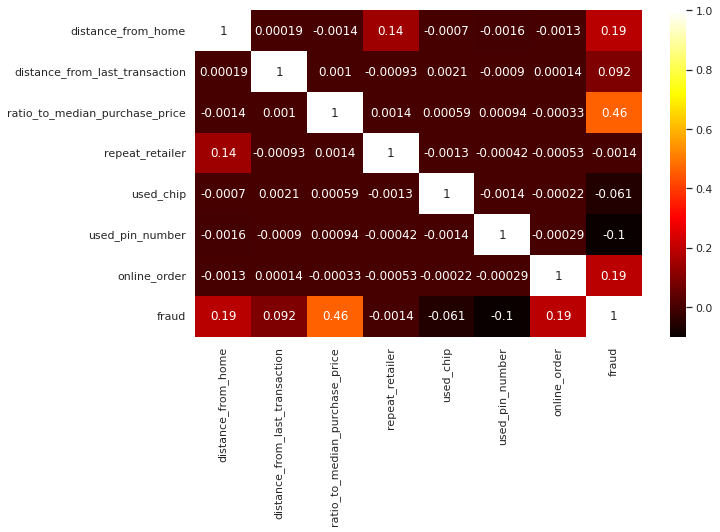

In [7]:
corr = df.corr()

sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True, cmap = "hot")

fraud
0.0    912597
1.0     87403
dtype: int64

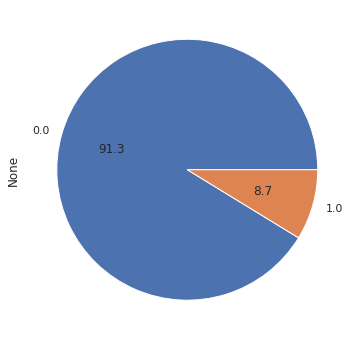

In [8]:
# Class distribution
# Real (class 0.0) meaning non-fraudulent transactions
# Fraud (class 1.0) meaning fraudulent transactions
df.value_counts("fraud").plot.pie(autopct = "%.1f")
df.value_counts("fraud")

**Under-sampling (Down Sampling)**

In [9]:
real = df[df["fraud"] == 0]
fraud = df[df["fraud"] == 1]

# Resampling the original dataset with 87,403 datapoints for both classes
real_resample = real.sample(n = 87403, random_state = 123)
fraud_resample = fraud.sample(n = 87403, random_state = 123)

# Creating new dataset consisting of equal class occurence 
df= pd.concat([real_resample, fraud_resample], axis = 0)

fraud
0.0    87403
1.0    87403
dtype: int64

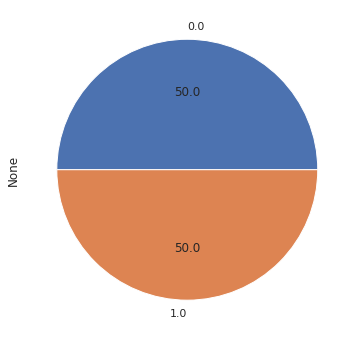

In [10]:
df.value_counts("fraud").plot.pie(autopct = "%.1f")
df.value_counts("fraud")

In [11]:
X = np.array(df.drop(columns = "fraud"))
y = np.array(df["fraud"])

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y , random_state=104,test_size=0.25, shuffle=True)

In [13]:
# Data scaling to produce good results
scale = MinMaxScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

**K Nearest Neighbors Classifier**

In [14]:
# Empty lists for appending each value of k
train_accuracy = []
test_accuracy = []

In [15]:
# Iterate through values of k and store results
for k in range(3, 16):
    knn = neighbors.KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    train_accuracy.append(knn.score(X_train, y_train))
    test_accuracy.append(knn.score(X_test, y_test))

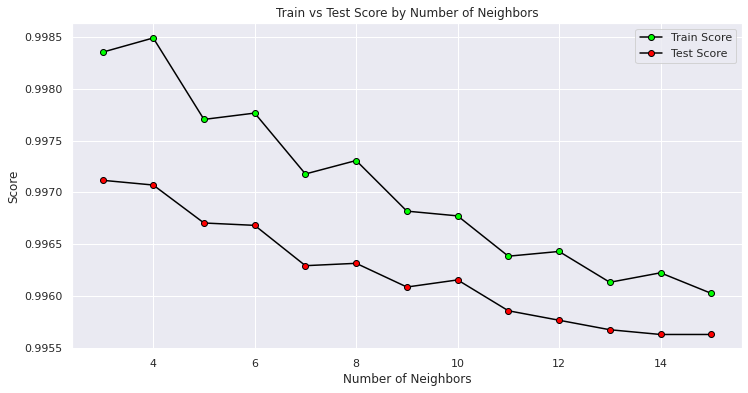

In [16]:
# Displaying model accuracy for different values of k
plt.figure(figsize = (12, 6))

plt.plot(range(3, 16), train_accuracy, label = "Train Score",
         marker = "o", markerfacecolor = "#00FF00", color = "#000000")

plt.plot(range(3, 16), test_accuracy, label = "Test Score", 
         marker = "o", markerfacecolor = "#FF0000", color = "#000000")

plt.xlabel("Number of Neighbors")
plt.ylabel("Score")
plt.title("Train vs Test Score by Number of Neighbors")
plt.legend()
plt.show()

**The accuracy of our KNN model decreases as the value of k increases. Let's use k = 3 for best performance.**

In [17]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [18]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[21839,    94],
       [   32, 21737]])

In [19]:
precision_score(y_test, y_pred)

0.9956941963263249

Text(84.5, 0.5, 'Truth')

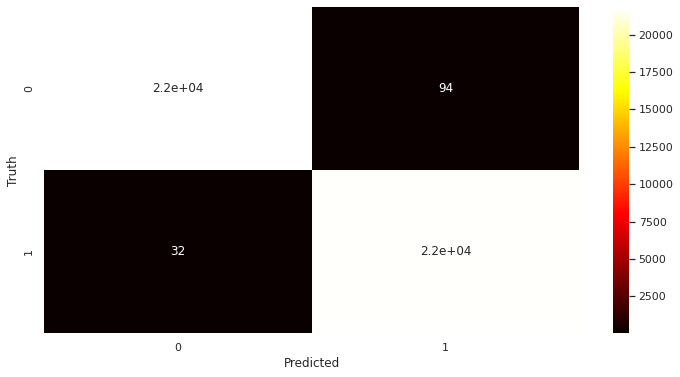

In [20]:
plt.figure(figsize = (12, 6))

sns.heatmap(cm, annot = True, cmap = "hot")
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [21]:
accuracy = knn.score(X_test, y_test)
print("KNN Accuracy:",accuracy)
print(classification_report(y_test, y_pred))

KNN Accuracy: 0.9971168367580431
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     21933
         1.0       1.00      1.00      1.00     21769

    accuracy                           1.00     43702
   macro avg       1.00      1.00      1.00     43702
weighted avg       1.00      1.00      1.00     43702



**Decision Tree Classifier**

In [22]:
dt = DecisionTreeClassifier(random_state = 5)  
dt.fit(X_train, y_train) 
y_pred = dt.predict(X_test)

In [23]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[21930,     3],
       [    0, 21769]])

In [24]:
precision_score(y_test, y_pred)

0.9998622083409884

Text(84.5, 0.5, 'Truth')

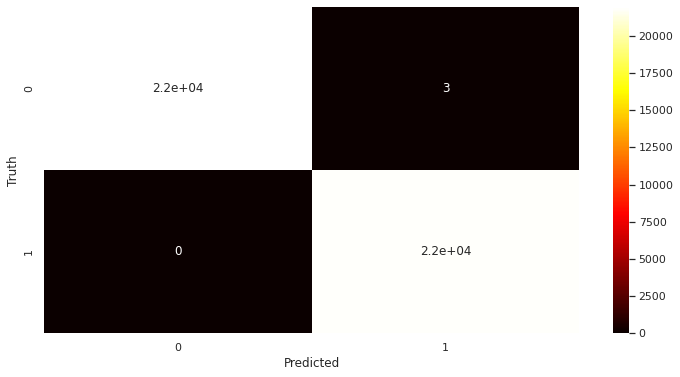

In [25]:
plt.figure(figsize = (12, 6))

sns.heatmap(cm, annot = True, cmap = "hot")
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [26]:
accuracy = dt.score(X_test, y_test)
print("DT Accuracy:",accuracy)
print(classification_report(y_test, y_pred))

DT Accuracy: 0.9999313532561439
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     21933
         1.0       1.00      1.00      1.00     21769

    accuracy                           1.00     43702
   macro avg       1.00      1.00      1.00     43702
weighted avg       1.00      1.00      1.00     43702



**Random Forest Classifier**

In [27]:
rf = RandomForestClassifier(random_state = 5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [28]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[21932,     1],
       [    0, 21769]])

In [29]:
precision_score(y_test, y_pred)

0.9999540652273772

Text(84.5, 0.5, 'Truth')

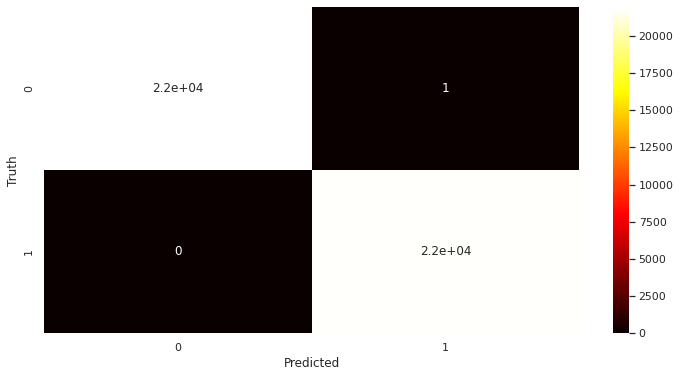

In [30]:
plt.figure(figsize = (12, 6))

sns.heatmap(cm, annot = True, cmap = "hot")
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [31]:
accuracy = rf.score(X_test, y_test)
print("RF Accuracy:",accuracy)
print(classification_report(y_test, y_pred))

RF Accuracy: 0.999977117752048
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     21933
         1.0       1.00      1.00      1.00     21769

    accuracy                           1.00     43702
   macro avg       1.00      1.00      1.00     43702
weighted avg       1.00      1.00      1.00     43702



**Thank you for viewing this notebook. Please feel free to provide any feedback on this notebook! I am always looking to improve.**